# Model comparison

The purpose of this notebook is to compare the performance of our SVM model to alternatives. As a testing dataset, the four-substrate dataset from A. Thaliana is used.

In [2]:
import sys
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.svm import LinearSVC

from subpred.transporter_dataset import create_dataset
from subpred.eval import full_test, get_independent_test_set, preprocess_pandas, optimize_hyperparams
from subpred.compositions import calculate_aac, calculate_paac
from subpred.pssm import calculate_pssms_notebook
from subpred.eval import preprocess_pandas


LOG_FILE = "../logs/athaliana_amino_sugar_potassium_feature_transformer.log"

## Dataset creation

In [3]:
sodium = ["Q2UVJ5", "O04034", "Q9FKP1", "Q9LJI2", "Q9SYG9", "Q84TI7"]
gdu = ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
df_all = create_dataset(
    keywords_substrate_filter=[
        "Amino-acid transport",
        "Electron transport",
        "Sugar transport",
        "Potassium transport",
    ],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    outliers=gdu + sodium,
    verbose=True,
    tax_ids_filter=[3702],
    output_log=LOG_FILE,
    sequence_clustering=70,
)

cd-hit: clustered 297 sequences into 223 clusters at threshold 70


In [4]:
labels = df_all.keywords_transport

In [5]:
df_aac = calculate_aac(df_all.sequence)
df_paac = calculate_paac(df_all.sequence)
df_pssm = calculate_pssms_notebook(df_all.sequence)

### Preparing the features:

Each feature type gets encoded in the column names of the feature dataframe, separated with a double-underscore from the feature name:

In [6]:
df_aac.columns = df_aac.columns.to_series().apply(lambda x: f"AAC__{x}")
df_aac.head()

,AAC__A,AAC__C,AAC__D,AAC__E,AAC__F,AAC__G,AAC__H,AAC__I,AAC__K,AAC__L,AAC__M,AAC__N,AAC__P,AAC__Q,AAC__R,AAC__S,AAC__T,AAC__V,AAC__W,AAC__Y
Uniprot,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,0.033531,0.033531,0.039448,0.029586,0.039448,0.055227,0.041420,0.086785,0.017751,0.025641
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,0.029046,0.033195,0.041494,0.016598,0.029046,0.087137,0.058091,0.103734,0.016598,0.053942
P0DKI1,0.079812,0.004695,0.018779,0.028169,0.042254,0.065728,0.023474,0.065728,0.046948,0.098592,0.023474,0.032864,0.042254,0.046948,0.056338,0.122066,0.084507,0.061033,0.004695,0.051643
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,0.031189,0.038986,0.035088,0.035088,0.037037,0.064327,0.058480,0.081871,0.017544,0.029240
Q56ZZ7,0.128205,0.009158,0.020147,0.038462,0.051282,0.106227,0.003663,0.058608,0.031136,0.120879,0.020147,0.018315,0.027473,0.027473,0.040293,0.115385,0.051282,0.089744,0.014652,0.027473


In [7]:
df_paac.columns = df_paac.columns.to_series().apply(lambda x: f"PAAC__{x}")
df_paac.head()

,PAAC__AA,PAAC__AC,PAAC__AD,PAAC__AE,PAAC__AF,PAAC__AG,PAAC__AH,PAAC__AI,PAAC__AK,PAAC__AL,...,PAAC__YM,PAAC__YN,PAAC__YP,PAAC__YQ,PAAC__YR,PAAC__YS,PAAC__YT,PAAC__YV,PAAC__YW,PAAC__YY
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.005929,0.001976,0.00000,0.000000,0.005929,0.005929,0.000000,0.003953,0.003953,0.009881,...,0.001976,0.0,0.000000,0.000000,0.001976,0.000000,0.0,0.003953,0.000000,0.000000
Q84WN3,0.004167,0.000000,0.00000,0.004167,0.004167,0.004167,0.000000,0.008333,0.004167,0.008333,...,0.004167,0.0,0.000000,0.000000,0.004167,0.000000,0.0,0.004167,0.000000,0.004167
P0DKI1,0.014151,0.000000,0.00000,0.000000,0.004717,0.009434,0.000000,0.014151,0.000000,0.014151,...,0.000000,0.0,0.004717,0.009434,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
O04249,0.005859,0.001953,0.00000,0.003906,0.009766,0.011719,0.001953,0.003906,0.001953,0.005859,...,0.000000,0.0,0.000000,0.001953,0.000000,0.003906,0.0,0.001953,0.000000,0.000000
Q56ZZ7,0.011009,0.001835,0.00367,0.003670,0.007339,0.018349,0.000000,0.012844,0.003670,0.020183,...,0.000000,0.0,0.000000,0.000000,0.000000,0.003670,0.0,0.001835,0.001835,0.001835


In [8]:
def transform_pssm_col(col_name):
    values = col_name.split("_")
    aa_exchange = values[0]
    blastdb = values[1]
    iterations = values[2]
    return f"PSSM_{blastdb}_{iterations}__{aa_exchange}"
df_pssm.columns = df_pssm.columns.to_series().apply(transform_pssm_col)
df_pssm.head()

,PSSM_50_1__AA,PSSM_50_1__AR,PSSM_50_1__AN,PSSM_50_1__AD,PSSM_50_1__AC,PSSM_50_1__AQ,PSSM_50_1__AE,PSSM_50_1__AG,PSSM_50_1__AH,PSSM_50_1__AI,...,PSSM_90_3__VL,PSSM_90_3__VK,PSSM_90_3__VM,PSSM_90_3__VF,PSSM_90_3__VP,PSSM_90_3__VS,PSSM_90_3__VT,PSSM_90_3__VW,PSSM_90_3__VY,PSSM_90_3__VV
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.784223,0.252900,0.327146,0.238979,0.394432,0.350348,0.276102,0.545244,0.227378,0.317865,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q84WN3,0.664740,0.416185,0.462428,0.427746,0.624277,0.445087,0.456647,0.526012,0.479769,0.543353,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
P0DKI1,0.759494,0.265823,0.348101,0.227848,0.379747,0.322785,0.303797,0.417722,0.278481,0.348101,...,0.490798,0.398773,0.447853,0.705521,0.331288,0.453988,0.417178,0.533742,0.871166,0.478528
O04249,0.735484,0.286022,0.352688,0.281720,0.479570,0.352688,0.318280,0.531183,0.279570,0.417204,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
Q56ZZ7,0.798913,0.173913,0.217391,0.153986,0.389493,0.251812,0.190217,0.481884,0.148551,0.367754,...,0.488636,0.433442,0.472403,0.608766,0.420455,0.461039,0.462662,0.514610,0.657468,0.470779


In [9]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined.head()

,AAC__A,AAC__C,AAC__D,AAC__E,AAC__F,AAC__G,AAC__H,AAC__I,AAC__K,AAC__L,...,PSSM_90_3__VL,PSSM_90_3__VK,PSSM_90_3__VM,PSSM_90_3__VF,PSSM_90_3__VP,PSSM_90_3__VS,PSSM_90_3__VT,PSSM_90_3__VW,PSSM_90_3__VY,PSSM_90_3__VV
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
P0DKI1,0.079812,0.004695,0.018779,0.028169,0.042254,0.065728,0.023474,0.065728,0.046948,0.098592,...,0.490798,0.398773,0.447853,0.705521,0.331288,0.453988,0.417178,0.533742,0.871166,0.478528
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
Q56ZZ7,0.128205,0.009158,0.020147,0.038462,0.051282,0.106227,0.003663,0.058608,0.031136,0.120879,...,0.488636,0.433442,0.472403,0.608766,0.420455,0.461039,0.462662,0.514610,0.657468,0.470779


Now, the feature dataframe contains six different features:

- AAC
- PAAC
- PSSM (1 iteration, Uniref50)
- PSSM (3 iterations, Uniref50)
- PSSM (1 iteration, Uniref90)
- PSSM (3 iterations, Uniref90)

The feature type and the features are separated by a double-underscore.

The custom transformer code:

In [10]:
# this should be used this in combination with a standardscaler, since the features are not in the same ranges.
class FeatureCombinator(BaseEstimator, TransformerMixin):
    # feature_names have the shape "feature_type__feature_name", separated by two underscores.
    def __init__(self, feature_names: np.array, feature_types: np.array):
        # grid search sets these fields with the values from the parameter grid, then fit is called.
        self.feature_names = feature_names
        self.feature_types = feature_types

    def __filter_column_names(self):
        for feature_name in self.feature_names:
            feature_type = feature_name.split("__")[0]
            yield feature_type in self.feature_types

    def fit(self, X, y=None):
        self.mask = list(self.__filter_column_names())
        return self

    def transform(self, X, y=None):
        # would throw error with pandas dataframes because .loc is missing
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
        X = X[:, self.mask]
        return X

## Preparing data:

In [11]:
X, y, _, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)

In [12]:
feature_names = df_combined.columns.values
feature_types = df_combined.columns.to_series().apply(lambda x: x.split("__")[0]).unique()

print(feature_types)

# all possible subsets of feature_types, (except the empty set of course)
all_subsets = []
for num_features in range(1,len(feature_types)):
    subset = [list(x) for x in combinations(feature_types, num_features)]
    all_subsets.extend(subset)

individual_features = [["AAC"], ["PAAC"], ["PSSM_50_1"], ["PSSM_50_3"], ["PSSM_90_1"], ["PSSM_90_3"]]

['AAC' 'PAAC' 'PSSM_50_1' 'PSSM_50_3' 'PSSM_90_1' 'PSSM_90_3']


## Evaluation

### RBF-SVM (Model that was used in the rest of the project)

In [13]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SVC()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "svc__decision_function_shape": ["ovo", "ovr"],
        "svc__class_weight": ["balanced", None],
        "svc__C": [1, 0.1, 10, 100],
        "svc__gamma": ["scale", 0.01, 0.1, 1],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.974
{'featurecombinator__feature_types': ['AAC', 'PSSM_50_3', 'PSSM_90_1', 'PSSM_90_3'], 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale'}
0.976


### RF

In [14]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), RandomForestClassifier(random_state=1)
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "randomforestclassifier__class_weight": ["balanced"],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.867
{'featurecombinator__feature_types': ['AAC', 'PAAC', 'PSSM_50_1', 'PSSM_50_3'], 'randomforestclassifier__class_weight': 'balanced'}
0.811


### RF (optimized)

In [26]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types),
    StandardScaler(),
    RandomForestClassifier(random_state=1),
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "randomforestclassifier__class_weight": ["balanced"],
        "randomforestclassifier__n_estimators": [1,100],
        "randomforestclassifier__max_depth": [3, 6, 9],
        "randomforestclassifier__min_samples_split": [2, 4, 6, 8, 10],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__max_leaf_nodes": [5, 10, 20, 30],
        # 'randomforestclassifier__max_features': [None],
        # 'randomforestclassifier__bootstrap': [True,False],
        # 'randomforestclassifier__criterion' :['gini', 'entropy'],
        "featurecombinator__feature_types": all_subsets,
    },
    scoring="f1_macro",
    return_train_score=True,
    n_jobs=-1,
)

gsearch.fit(X_train, y_train)

print("train (grid search test)",gsearch.best_score_.round(3))

best_results = {
    name: value[gsearch.best_index_] for name, value in gsearch.cv_results_.items()
}
print("grid search train",best_results["mean_train_score"].round(3))

print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print("test",test_score.round(3))



train (grid search test) 0.892
grid search train 0.999
{'featurecombinator__feature_types': ['AAC', 'PAAC', 'PSSM_50_3', 'PSSM_90_1'], 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_leaf_nodes': 20, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 100}
test 0.878


In [25]:
print("train (grid search test)",gsearch.best_score_.round(3))

best_results = {
    name: value[gsearch.best_index_] for name, value in gsearch.cv_results_.items()
}
print("grid search train",best_results["mean_train_score"].round(3))

print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print("test",test_score.round(3))

train (grid search test) 0.907
grid search train 1.0
{'featurecombinator__feature_types': ['AAC', 'PAAC', 'PSSM_50_1', 'PSSM_50_3', 'PSSM_90_1'], 'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 6, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__max_leaf_nodes': 20, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 100}
test 0.807


### KNN

In [29]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), KNeighborsClassifier()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "kneighborsclassifier__n_neighbors":[2,1,3,4,5],
        "kneighborsclassifier__weights":["uniform","distance"],
        "kneighborsclassifier__p":[1,2,3],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.914
{'featurecombinator__feature_types': ['AAC', 'PSSM_50_1', 'PSSM_50_3', 'PSSM_90_1'], 'kneighborsclassifier__n_neighbors': 2, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'distance'}
0.866


### SGD

In [15]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SGDClassifier(random_state=1)
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        # "randomforestclassifier__class_weight": ["balanced"],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.961
{'featurecombinator__feature_types': ['PSSM_50_3', 'PSSM_90_3']}
0.974


### SGD (optimized)

In [78]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SGDClassifier(random_state=1)
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "sgdclassifier__class_weight": ["balanced"],
        "sgdclassifier__penalty": ["elasticnet"],
        "sgdclassifier__l1_ratio": [0, 0.15, 0.5, 0.75, 1],
        "sgdclassifier__loss": ["hinge"],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
# l1_ratio = 0 is equivalent to penalty=l2, which is the default parameter.
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.975
{'featurecombinator__feature_types': ['AAC', 'PSSM_50_3', 'PSSM_90_1'], 'sgdclassifier__class_weight': 'balanced', 'sgdclassifier__l1_ratio': 0, 'sgdclassifier__loss': 'hinge', 'sgdclassifier__penalty': 'elasticnet'}
0.976


### Bayes

In [17]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), GaussianNB()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        # "randomforestclassifier__class_weight": ["balanced"],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.802
{'featurecombinator__feature_types': ['AAC']}
0.746


### Perceptron

In [18]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), Perceptron(random_state=1)
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "perceptron__class_weight": ["balanced"],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.972
{'featurecombinator__feature_types': ['PSSM_50_3', 'PSSM_90_3'], 'perceptron__class_weight': 'balanced'}
0.974


### Regularized Perceptron

In [79]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types),
    StandardScaler(),
    Perceptron(random_state=1),
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "perceptron__class_weight": ["balanced"],
        "perceptron__penalty": ["elasticnet"],
        # "perceptron__tol": [1e-3, 1e-2, 1e-4],
        # "perceptron__fit_intercept": [True,False],
        # "perceptron__eta0": [1,0.1,10],
        # "perceptron__alpha": [0.0001,0.00001,0.001],
        "perceptron__l1_ratio": [0, 0.15, 0.5, 0.75, 1],
        # "featurecombinator__feature_types": all_subsets,
        "featurecombinator__feature_types":all_subsets#[["AAC"], ["PAAC"], ["PSSM_50_1"], ["PSSM_50_3"], ["PSSM_90_1"], ["PSSM_90_3"]]
    },
    scoring="f1_macro",
    n_jobs=-1,
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))


0.988
{'featurecombinator__feature_types': ['PSSM_50_3', 'PSSM_90_1'], 'perceptron__class_weight': 'balanced', 'perceptron__l1_ratio': 0.5, 'perceptron__penalty': 'elasticnet'}
1.0


## Other independent test sets

value
type          dataset       
f1_macro_mean test     0.969
              train    0.978

<AxesSubplot:>

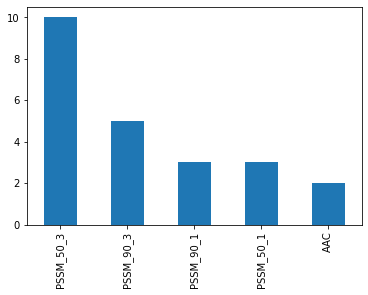

In [48]:
records = []
for random_seed in [7553, 4992, 2189, 4299, 2961, 4209, 4664, 9374, 8123, 443]:
    X, y, _, sample_names = preprocess_pandas(
        df_combined, labels, return_names=True
    )
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2, random_state=random_seed)
    pipe = make_pipeline(
        FeatureCombinator(feature_names, feature_types),
        StandardScaler(),
        Perceptron(random_state=1),
    )

    gsearch = GridSearchCV(
        pipe,
        param_grid={
            "perceptron__class_weight": ["balanced"],
            "perceptron__penalty": ["elasticnet"],
            # "perceptron__tol": [1e-3, 1e-2, 1e-4],
            # "perceptron__fit_intercept": [True,False],
            # "perceptron__eta0": [1,0.1,10],
            # "perceptron__alpha": [0.0001,0.00001,0.001],
            "perceptron__l1_ratio": [0, 0.15, 0.5, 0.75, 1],
            "featurecombinator__feature_types": all_subsets#[["AAC"], ["PAAC"], ["PSSM_50_1"], ["PSSM_50_3"], ["PSSM_90_1"], ["PSSM_90_3"]],
        },
        scoring="f1_macro",
        n_jobs=-1,
    )

    gsearch.fit(X_train, y_train)
    test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
    records.append([random_seed,"train", "f1_macro_mean", gsearch.best_score_])
    records.append([random_seed,"train", "selected_features", gsearch.best_params_["featurecombinator__feature_types"]])
    records.append([random_seed,"test", "f1_macro_mean", test_score])

df_records = pd.DataFrame.from_records(records, columns=["random_seed","dataset", "type", "value"])
display(df_records[df_records.type == "f1_macro_mean"].drop("random_seed", axis=1).groupby(["type", "dataset"]).mean().round(3))
display(df_records[df_records.type == "selected_features"].value.explode().value_counts().plot.bar())

In [47]:
print("F1 std train",df_records[(df_records.dataset == "train") & (df_records.type == "f1_macro_mean")].value.std().round(3))
print("F1 std test",df_records[(df_records.dataset == "test") & (df_records.type == "f1_macro_mean")].value.std().round(3))

F1 std train 0.006
F1 std test 0.024


## Conclusion

On the independent test set with random_state=42, the Perceptron outperforms the other models, although most of the other models still produce good results. 